In [64]:
import numpy as np
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import random
from hurst import compute_Hc, random_walk
import matplotlib.pyplot as plt

In [141]:
# For better performance GPU is recommended

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Yor device is: {device}')

Yor device is: cpu


In [66]:
from fbm import FBM

In [147]:
grid_points = 128
num_of_train = 40000
num_of_test = 10000
batch = 100
epochs = 5

normalised = True
# If set to False, it is a neural net without conv. layer
CNN = True


In [103]:
# Generating H randomly and then creating fGn-s, the file is created using these commented codes
# %%time
# train_data = []


# num_test = num_of_train
# rand_test = []

# for j in range(num_test):
#   H = random.uniform(0.01,1.0)
  
#   f = FBM(n=grid_points, hurst=H, length=1, method='daviesharte')
  

#   train_data.append((f.fgn(), H))


In [104]:
# H generated from 0.05 grid
# %%time

# train_data = []

# for H in np.arange(0.05,1.0,0.05):
#   f = FBM(n=grid_points, hurst=H, length=1, method='daviesharte')
#   for i in range(500):
#     train_data.append((f.fgn(), H))

# from random import shuffle
# shuffle(train_data)

In [105]:
# # Training data containing data where H is taken from discrete grid
# with open('notrandom_regression_train_data_grid128', 'rb') as fp:
#     train_data = pickle.load(fp)

In [106]:
# Opening the file containing the data
with open('regression_train_data_grid128', 'rb') as fp:
    train_data = pickle.load(fp)[:num_of_train]

In [107]:

if normalised:
    normalised_train_data = []
    for tup in train_data:
        normalised_train_data.append((tup[0]/np.average(np.abs(tup[0])),tup[1]))
    train_data = normalised_train_data

In [151]:
# Testing data, random H
with open ('regression_train_data_grid128', 'rb') as fp:
    save = pickle.load(fp)[num_of_train:]

In [152]:
if normalised:
    normalised_save_data = []
    for tup in save:
        normalised_save_data.append((tup[0]/np.average(np.abs(tup[0])),tup[1]))
    save = normalised_save_data

In [153]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(save, batch_size=batch, shuffle=False)

In [111]:
if not CNN:
    class CNN_simplistic(nn.Module):
        def __init__(self):
            super().__init__()



            self.fc1 = nn.Linear(grid_points, 256)
            self.fc2 = nn.Linear(256, 190)
            self.fc3 = nn.Linear(190, 190)
            self.fc4 = nn.Linear(190, 1)
            

        def forward(self, x):

            x = self.fc1(x)
            x = F.relu(x)

            #fc layer 2
            x = self.fc2(x)
            x = F.relu(x)

            #fc layer 3
            x = self.fc3(x)
            x = F.relu(x)

            x=self.fc4(x)

            return x

In [112]:
if CNN:
    p=0.2
    class CNN_simplistic(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv1d(1, 32, padding = 'same', kernel_size = 11)
            self.conv2 = nn.Conv1d(32, 32, padding = 'same',kernel_size = 11)
            self.conv3 = nn.Conv1d(32, 64, padding = 'same',kernel_size = 11)
            self.conv4 = nn.Conv1d(64, 64, padding = 'same',kernel_size = 11)

            self.fc1 = nn.Linear(grid_points*64//(4*4*2*2), 256)
            self.fc2 = nn.Linear(256, 190)
            self.fc3 = nn.Linear(190, 100)
            self.fc4 = nn.Linear(100, 1)
            self.dropout = nn.Dropout(p)

        def forward(self, x):

            x = self.conv1(x)
            x = F.relu(x)
            x = F.max_pool1d(x,kernel_size = 4)

            x = self.dropout(self.conv2(x))
            x = F.relu(x)
            x = F.max_pool1d(x,kernel_size = 4)


            x = self.conv3(x)
            x = F.relu(x)
            x = F.max_pool1d(x,kernel_size = 2)

            x = self.dropout(self.conv4(x))
            x = F.relu(x)
            x = F.avg_pool1d(x,kernel_size = 2)


            x = x.view(-1,grid_points*64//(4*4*2*2))
            x = self.fc1(x)
            x = F.relu(x)

            #fc layer 2
            x = self.fc2(x)
            x = F.relu(x)

            #fc layer 3
            x = self.fc3(x)
            x = F.relu(x)

            x=self.fc4(x)

            return x

In [113]:
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange


## Training
# Instantiate model  
model_simp = CNN_simplistic().double().to(device) 



# Loss and Optimizer
base_optimizer = torch.optim.SGD
optimizer = torch.optim.Adam(model_simp.parameters(), lr=0.001)
criterion = nn.MSELoss()




# Iterate through train set minibatchs 
for epoch in trange(epochs):  
    for images, labels in tqdm(train_loader):
        images = images[:,None,:].to(device)
        labels = labels.to(device)
        # Zero out the gradients
        optimizer.zero_grad()

        # ADAM
        # Forward pass
        x = images
        y = model_simp(x)
        loss = criterion(torch.squeeze(y), torch.squeeze(labels))


        
        # Backward pass
        loss.backward()
        optimizer.step()

In [114]:
# # Test loader for Hurst package:
# from hurst import compute_Hc, random_walk
# num = 1000
# rand_test = []

# for j in range(num):
#     H = random.uniform(0.001,1.0)
  
#     fbm = random_walk(128, proba=H)
  

#     rand_test.append((np.array(fbm), H))

# test_loader = torch.utils.data.DataLoader(rand_test, batch_size=batch, shuffle=False)


In [115]:
## Testing alone
for allowed_error in np.arange(0.01,0.1,0.01):
    correct = 0
    
    


    with torch.no_grad():
        # Iterate through test set minibatchs 
        for images, labels in test_loader:


            images = images[:,None,:].to(device)
            labels = labels.to(device)

            # Forward pass
            x = images  
#             print(labels.shape)
            
            y = torch.reshape(model_simp(x), (batch,))
            
            


            correct += torch.sum((abs(labels-y)<allowed_error).float())
    
    print(f'Accuracy with threshold {allowed_error}: {100*correct/num_of_test}%')

Accuracy with threshold 0.01: 14.109999656677246%
Accuracy with threshold 0.02: 29.200000762939453%
Accuracy with threshold 0.03: 42.41999816894531%
Accuracy with threshold 0.04: 55.5099983215332%
Accuracy with threshold 0.05: 65.91000366210938%
Accuracy with threshold 0.060000000000000005: 74.08999633789062%
Accuracy with threshold 0.06999999999999999: 80.41999816894531%
Accuracy with threshold 0.08: 85.86000061035156%
Accuracy with threshold 0.09: 90.01000213623047%


In [142]:
# # # Testing data, random H, not regularised
# with open ('regression_train_data_grid128', 'rb') as fp:
#     save = pickle.load(fp)[num_of_train:]
# test_loader = torch.utils.data.DataLoader(save, batch_size=batch, shuffle=False)

In [196]:
# ## Testing R/S
# for allowed_error in np.arange(0.01,0.1,0.01):
# #     correct = 0
#     RScorrect = 0
    


#     with torch.no_grad():
#         # Iterate through test set minibatchs 
#         for images, labels in test_loader:


#             images = images[:,None,:].to(device)
#             labels = labels.to(device)

#             # Forward pass
#             x = images  
#     #         print(labels)
            
# #             y = torch.reshape(model_simp(x), (batch,))
#             x = x.view(-1,128)
#             for i in range(batch):
#                 H,_,_ = compute_Hc(x[i], kind='change', simplified=True)
#                 if np.abs(H-labels[i])<allowed_error:
#                     RScorrect+=1


# #             correct += torch.sum((abs(labels-y)<allowed_error).float())
    
# #     print(f'NN accuracy with threshold {allowed_error}: {100*correct/num_of_test}%')
#     print(f'R/S accuracy with threshold {allowed_error}: {100*RScorrect/num_of_test}%')

In [185]:
# Individual checking
hurst = 0.8
a = 0
for i in range(10):
    f = FBM(n=grid_points, hurst=hurst, length=1, method='daviesharte')
    g =f.fgn()
    g = g/np.average(np.abs(g))

    t = torch.tensor(g)[None,:].to(device)
    a += float(model_simp(t))
    print(float(model_simp(t)))
    
print(a/10)

0.7970615438984928
0.7304589949796204
0.7357165872622481
0.8286150497919827
0.7773985595145659
0.7274039518038068
0.7795814676508706
0.851715822046263
0.7315995607442928
0.8347689183963088
0.7764696168681996


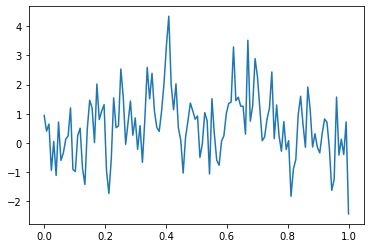

In [139]:
f = FBM(n=grid_points, hurst=hurst, length=1, method='daviesharte')
g =f.fgn()
g = g/np.average(np.abs(g))
plt.plot(np.linspace(0,1,128),g)

In [192]:



# Use random_walk() function or generate a random walk series manually:
# series = random_walk(99999, cumprod=True)
# np.random.seed(42)
# random_changes = 1. + np.random.randn(99999) / 1000.
# series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(g, kind='change', simplified=True)

print(H)

0.8425562820379541


In [121]:
# import copy
# from hurst import compute_Hc, random_walk
# newfbm = random_walk(129, proba=hurst)

# H, c, data = compute_Hc(newfbm, kind='random_walk', simplified=True)
# print(H)

# # newfbm = np.array(newfbm)
# # lis = []
# # for i in range(128):
# #     lis.append(newfbm[i+1]-newfbm[i])
# # lis  = np.array(lis)
# # lis_orig = copy.deepcopy(lis)

# # lis = torch.tensor(lis)[None,:].to(device)
# # model_simp(lis)


In [122]:
# a = 0
# for i in range(20):
#     newfbm = random_walk(129, proba=hurst)
#     newfbm = np.array(newfbm)
#     lis = []
#     for i in range(128):
#         lis.append(newfbm[i+1]-newfbm[i])
#     lis  = np.array(lis)
#     lis_orig = copy.deepcopy(lis)/np.average(np.abs(lis))
#     plt.plot(np.linspace(0,1,128),lis_orig)
#     lis = torch.tensor(lis_orig)[None,:].to(device)
#     a += float(model_simp(lis))
#     print(model_simp(lis))
# print()
# print(a/20)

In [123]:
import pandas as pd

In [124]:
import yfinance as yf

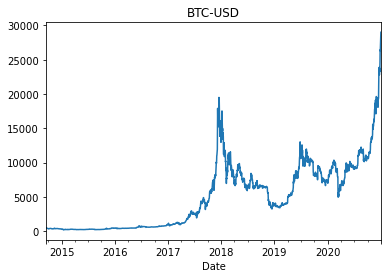

In [269]:
markets = ['AAPL','GOOGL','BTC-USD','BE.BE','GBPEUR=X','TSLA','CL=F']
market = markets[2]
spy_df = yf.download(market, 

                     start="2010-01-01", 

                     end="2020-12-31", 

                     progress=False)

spy_df["Adj Close"].plot(title=market);

In [270]:
# markets = ['AAPL','GOOGL','BTC-USD','BE.BE','GBPEUR=X','TSLA','CL=F']
# market = markets[-1]
# spy_df = yf.download(market, 

#                      start="2020-01-01", 

#                      end="2020-07-31", 

#                      progress=False)

# spy_df["Adj Close"].plot(title=market);

In [271]:
start = 0
values = spy_df["Adj Close"].values

values = np.array(values)
values = values[start:start+129]

H, _, _ = compute_Hc(values, kind='random_walk', simplified=True)
print(H)

values = np.diff(values)
values = values/np.average(np.abs(values))
#     plt.plot(values)

values = torch.tensor(values)[None,:].to(device)

print(model_simp(values))

0.5470009589386877
tensor([[0.5525]], dtype=torch.float64, grad_fn=<AddmmBackward0>)


In [272]:
sumH = []
for start in range(0,len(spy_df["Adj Close"].values)-129):
    values = spy_df["Adj Close"].values

    values = np.array(values)
    values = values[start:start+129]


    values = np.diff(values)
    values = values/np.average(np.abs(values))


    values = torch.tensor(values)[None,:].to(device)
    
    sumH.append(np.array([float(model_simp(values)),start]))
    
min_place = np.argmin(np.array(sumH)[:,0])
min_H = np.min(np.array(sumH)[:,0])
max_place = np.argmax(np.array(sumH)[:,0])
max_H = np.max(np.array(sumH)[:,0])

print('Minimal H')
print(min_H)
print(min_place)
print('Maximal H and place')
print(max_H)
print(max_place)
print('Average H')
print(np.average(np.array(sumH)[:,0]))

Minimal H
0.37777229376753896
446
Maximal H and place
0.7793955277504557
1049
Average H
0.5388220523000625


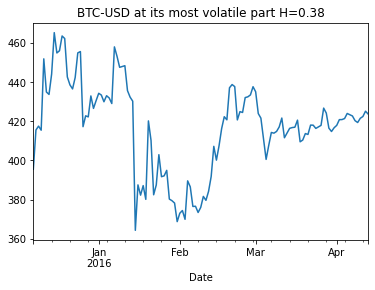

In [273]:
spy_df["Adj Close"][min_place:min_place+129].plot(title=market+' at its most volatile part '+f'H={round(min_H,2)}');

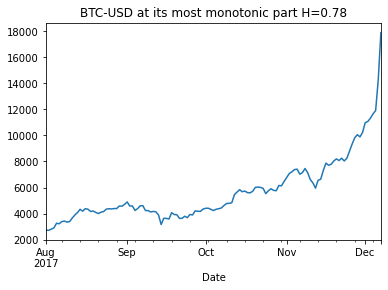

In [274]:
spy_df["Adj Close"][max_place:max_place+129].plot(title=market+' at its most monotonic part '+f'H={round(max_H,2)}');

In [275]:
# values = torch.tensor(values)[None,:].to(device)
# model_simp(values)

In [276]:
# start = 1
# values = spy_df["Adj Close"].values

# values = np.array(values)
# values = values[0:10*128+1:10]

# H, c, data = compute_Hc(values, kind='random_walk', simplified=True)
# print(H)

# lis = []
# for i in range(128):
#     lis.append(values[i+1]-values[i])
# values = np.array(lis)
# values = values/np.average(np.abs(values))
# # plt.plot(values)

In [277]:
# values = torch.tensor(values)[None,:].to(device)
# model_simp(values)